In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import math

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") #using gpu
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

Minimum value: 0.0117647061124444
Maximum value: 1.0


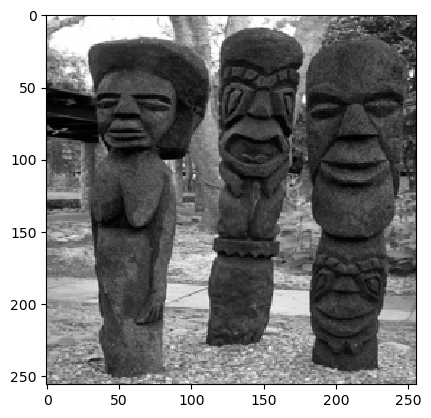

In [4]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)

min_value = np.min(testOutput.squeeze(0).cpu().numpy())
max_value = np.max(testOutput.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [5]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(2,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [6]:
kernel_size = 9
if kernel_size%2 == 0: #kernel size should be odd
    kernel_size = kernel_size-1

In [7]:
def create_gaussian_kernel(kernel_size=9, sigma=1.5):
    
    x = torch.arange(kernel_size) - (kernel_size - 1) / 2
    y = x.view(kernel_size, 1)
    x2y2 = x**2 + y**2
    
    gaussian_kernel = torch.exp(-x2y2 / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / (2 * np.pi * sigma**2)
    
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    return gaussian_kernel

In [8]:
#noise level map
def genNoiseMap(image, sigmaNorm):
    noiselvlMap = torch.full_like(image, sigmaNorm)
    return noiselvlMap
def combineImgandMap(imageNoised, noiselvlMap): #input image needs to be noised
    combinedInput = torch.cat((imageNoised, noiselvlMap), dim=1)
    return combinedInput
def addNoiseMap(imageNoised, sigmaNorm): #image needs to be noised, sigma should be normalized?
    noiselvlMap = genNoiseMap(imageNoised, sigmaNorm)
    return combineImgandMap(imageNoised, noiselvlMap)

In [9]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()
        
        self.k= create_gaussian_kernel(kernel_size, 1.5)

        self.k = self.k.view(1,1,kernel_size,kernel_size)
        self.k = self.k.to(device)
    # def forward(self, x, sigma=0):
    #     # A y

    #     #need new padding size with larger kernel
    #     padding_size = kernel_size//2
        
    #     x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
    #     #applying blur and noise
    #     y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
    #     return y

    def forward(self, x):
        # A y

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
        #applying blur without noise
        y = F.conv2d(x_padded, self.k)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        self.k = torch.transpose(self.k, 0, 1)

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        y_padded = F.pad(y, (padding_size, padding_size, padding_size, padding_size), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g

    def calcLoss(self, x, y):
        diff = self.forward(x) - y
        diffSquared = diff ** 2
        return 0.5*torch.sum(diffSquared)


In [10]:
def psnrCalc(mse, max):
    return 10*np.log10((max**2)/mse)


In [11]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
             sigmaNoiseMap,
             meas_sigma,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################

    x=x0 #keeping var names constant
    with torch.no_grad():
        for i in tqdm(range(max_iter)):
            # Look at PnP ISTA update steps
            
            z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)

            #adding noise map to z:
            z = addNoiseMap(z, sigmaNoiseMap)

            #plug into denoiser
            x = denoiser(z)
        
            #Feel free to add psnr/ssim tracking
            #track loss of (y-AX)^2
            #check if fista is running properly: set x=z, initailize image to zeros, simga=0 and you'll converge
            if i % 10 == 0:
                gt_img_np = gt_img.cpu().detach().numpy() if gt_img.is_cuda else gt_img.numpy()
                x_np = x.cpu().detach().numpy() if x.is_cuda else x.detach().numpy()
                meas_np = meas.cpu().detach().numpy() if meas.is_cuda else x.detach().numpy()
                #psnr of output
                mseTerm = mse(gt_img_np,x_np)
                curPsnr = psnrCalc(mseTerm, 1)
                curLoss = A.calcLoss(x, meas)
        
                #psnr of measurement
                mseTermMeas = mse(gt_img_np,meas_np)
                curPsnrMeas = psnrCalc(mseTermMeas, 1)

                psnrList.append(curPsnr)
                lossList.append(curLoss) #x is clean image, y is measurement
                print(f"At iter {i}, loss is: {curLoss}, PSNR of output is: {curPsnr}, PSNR of input is: {curPsnrMeas}");
    return x

In [12]:
findBestStepSize = False

In [13]:
max_iter = 200
stepsize = [2, 1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05, 0.01] # play with this
meas_sigma = 15 / 255 # play with this (note that it does not need to be same as the sigma you used for training)
bestPsnr = float('-inf')
bestStepSize = 0
#sigma for noise map
sigmaSampled = torch.randint(1,50,(1,1)).item() #each image have diff sigma
sigmaNoiseMap = sigmaSampled/255

A = BlurModel().to(device) # forward model

clean_img = preprocess(image).unsqueeze(0)
clean_img = clean_img.to(device)
blurry_img = A(clean_img)

network = UNetDenoise()
network.load_state_dict(torch.load('denoiserFinalWeightswNoiseMap.pth')) # Your NN you trained 
#denoiserFinalWeights.pth denoiserModelBestWeights.pth denoiserFinalWeightsEarlyStopped.pth denoiserModelBestWeightsEarlyStopped.pth denoiserFinalWeightswNoiseMap.pth 
network.eval()

x0 = blurry_img + meas_sigma * torch.randn_like(blurry_img)
network.to(device)
blurry_img = blurry_img.to(device)

x0 = x0.to(device)

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\desktop\miniconda3\envs\pyTorchEnv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  1%|          | 4/500 [00:00<00:13, 37.01it/s]

At iter 0, loss is: 25.564144134521484, PSNR of output is: 23.33073600065331, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:14, 32.78it/s]

At iter 10, loss is: 33.15007019042969, PSNR of output is: 22.896152108799885, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:12, 39.71it/s]

At iter 20, loss is: 33.16108703613281, PSNR of output is: 22.895158135494455, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:11, 42.59it/s]

At iter 30, loss is: 33.161399841308594, PSNR of output is: 22.895129355720552, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:00<00:10, 44.07it/s]

At iter 40, loss is: 33.16141128540039, PSNR of output is: 22.89512813796843, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:10, 44.07it/s]

At iter 50, loss is: 33.16141128540039, PSNR of output is: 22.895128047256726, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:09, 44.07it/s]

At iter 60, loss is: 33.16141128540039, PSNR of output is: 22.895128037096097, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 44.89it/s]

At iter 70, loss is: 33.16141128540039, PSNR of output is: 22.895128067531623, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:01<00:09, 45.01it/s]

At iter 80, loss is: 33.16141128540039, PSNR of output is: 22.895128066305936, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:09, 45.30it/s]

At iter 90, loss is: 33.161415100097656, PSNR of output is: 22.895128055211508, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:08, 45.24it/s]

At iter 100, loss is: 33.16141128540039, PSNR of output is: 22.89512803523957, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 44.95it/s]

At iter 110, loss is: 33.161415100097656, PSNR of output is: 22.895128062419197, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:08, 45.10it/s]

At iter 120, loss is: 33.16141128540039, PSNR of output is: 22.89512806758685, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:08, 45.10it/s]

At iter 130, loss is: 33.16141128540039, PSNR of output is: 22.89512803185385, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:03<00:07, 45.46it/s]

At iter 140, loss is: 33.161415100097656, PSNR of output is: 22.89512802488185, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:03<00:07, 45.36it/s]

At iter 150, loss is: 33.16141128540039, PSNR of output is: 22.89512805036506, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 45.09it/s]

At iter 160, loss is: 33.16141128540039, PSNR of output is: 22.89512804510545, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:07, 44.92it/s]

At iter 170, loss is: 33.16141128540039, PSNR of output is: 22.895128040610366, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:04<00:07, 44.88it/s]

At iter 180, loss is: 33.16141128540039, PSNR of output is: 22.89512805724322, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:06, 44.85it/s]

At iter 190, loss is: 33.16141128540039, PSNR of output is: 22.89512805740027, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:04<00:06, 44.79it/s]

At iter 200, loss is: 33.16141128540039, PSNR of output is: 22.895128096377316, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:04<00:06, 45.02it/s]

At iter 210, loss is: 33.16141128540039, PSNR of output is: 22.895128074243946, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:04<00:06, 44.75it/s]

At iter 220, loss is: 33.16141128540039, PSNR of output is: 22.895128061196726, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:05<00:05, 45.23it/s]

At iter 230, loss is: 33.16141128540039, PSNR of output is: 22.89512805086909, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:05<00:05, 45.52it/s]

At iter 240, loss is: 33.16141128540039, PSNR of output is: 22.89512803649813, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:05<00:05, 45.99it/s]

At iter 250, loss is: 33.16141128540039, PSNR of output is: 22.895128062124922, PSNR of input is: 24.799891158716747
At iter 260, loss is: 33.16141128540039, PSNR of output is: 22.895128078465277, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:06<00:04, 46.34it/s]

At iter 270, loss is: 33.16141128540039, PSNR of output is: 22.895128052758174, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:04, 46.07it/s]

At iter 280, loss is: 33.16141128540039, PSNR of output is: 22.89512804870832, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 45.88it/s]

At iter 290, loss is: 33.16141128540039, PSNR of output is: 22.895128039025053, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 45.82it/s]

At iter 300, loss is: 33.16141128540039, PSNR of output is: 22.8951280724175, PSNR of input is: 24.799891158716747


 62%|██████▏   | 311/500 [00:06<00:04, 45.94it/s]

At iter 310, loss is: 33.16141128540039, PSNR of output is: 22.89512806273313, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:07<00:03, 45.29it/s]

At iter 320, loss is: 33.16141128540039, PSNR of output is: 22.89512804404607, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:07<00:03, 44.60it/s]

At iter 330, loss is: 33.16141128540039, PSNR of output is: 22.89512807726284, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 44.62it/s]

At iter 340, loss is: 33.16141128540039, PSNR of output is: 22.89512806065784, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:07<00:03, 44.39it/s]

At iter 350, loss is: 33.16141128540039, PSNR of output is: 22.89512804864244, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:08<00:03, 44.13it/s]

At iter 360, loss is: 33.16141128540039, PSNR of output is: 22.895128060332723, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:08<00:02, 44.46it/s]

At iter 370, loss is: 33.161415100097656, PSNR of output is: 22.895128051830795, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:08<00:02, 44.75it/s]

At iter 380, loss is: 33.16141128540039, PSNR of output is: 22.895128053820194, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 44.84it/s]

At iter 390, loss is: 33.16141128540039, PSNR of output is: 22.89512805274471, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:08<00:02, 45.38it/s]

At iter 400, loss is: 33.16141128540039, PSNR of output is: 22.895128056816304, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:09<00:01, 44.67it/s]

At iter 410, loss is: 33.16141128540039, PSNR of output is: 22.895128042590258, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:09<00:01, 44.24it/s]

At iter 420, loss is: 33.16141128540039, PSNR of output is: 22.89512806022004, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:09<00:01, 44.19it/s]

At iter 430, loss is: 33.16141128540039, PSNR of output is: 22.8951280590474, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:09<00:01, 44.08it/s]

At iter 440, loss is: 33.16141128540039, PSNR of output is: 22.895128060730435, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:10<00:01, 44.54it/s]

At iter 450, loss is: 33.16141128540039, PSNR of output is: 22.89512806941836, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:10<00:00, 43.87it/s]

At iter 460, loss is: 33.16141128540039, PSNR of output is: 22.895128053344603, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:10<00:00, 43.96it/s]

At iter 470, loss is: 33.16141128540039, PSNR of output is: 22.895128065948175, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 44.12it/s]

At iter 480, loss is: 33.16141128540039, PSNR of output is: 22.895128063005707, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:11<00:00, 45.40it/s]

At iter 490, loss is: 33.16141128540039, PSNR of output is: 22.89512804349274, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

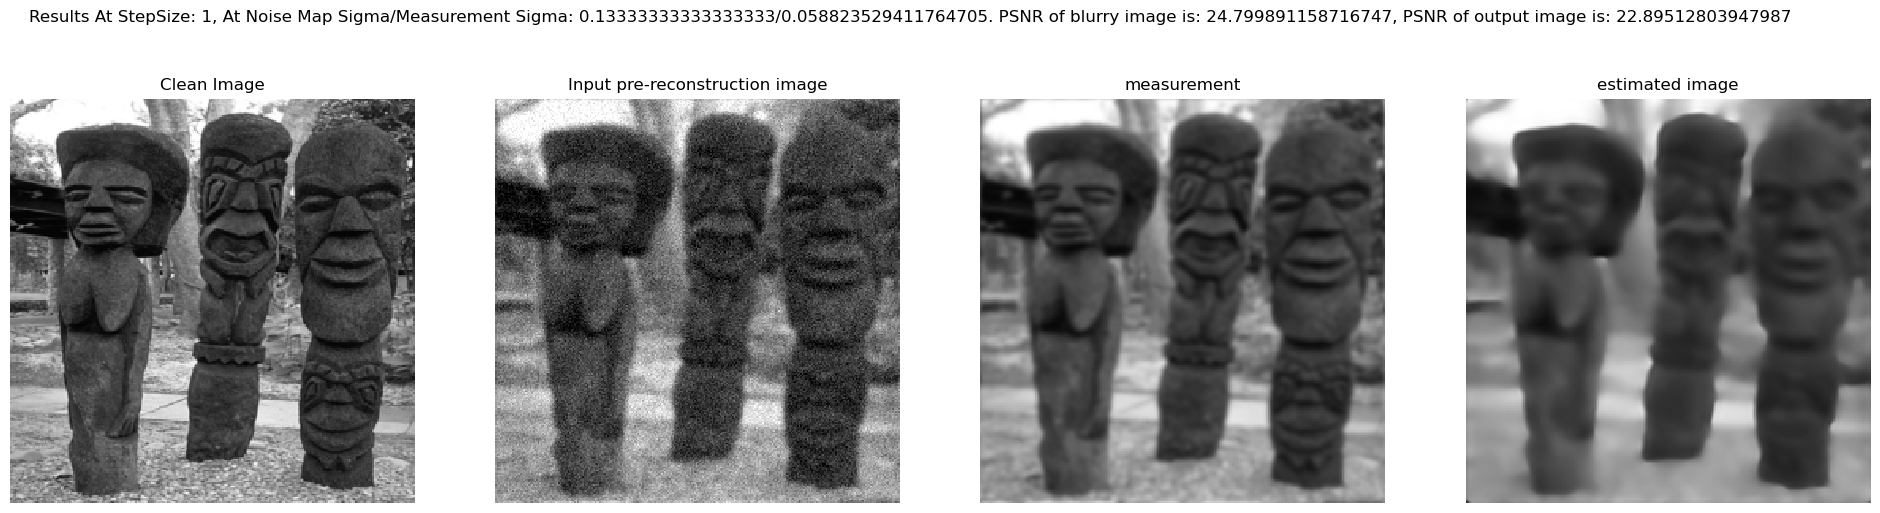

In [14]:
#best step size is found to be 1
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap,
                         meas_sigma = meas_sigma
                    )

blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {1}, At Noise Map Sigma/Measurement Sigma: {sigmaNoiseMap}/{meas_sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')

In [15]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

print(f'Final result PSNR of blurred image {finalPsnrMeas}')
print(f'Final result PSNR of reconstructed image {finalPsnrOutput}')

Final result PSNR of blurred image 24.799891158716747
Final result PSNR of reconstructed image 22.89512803947987


In [16]:
import scipy

In [17]:
def objFuncStepSize(stepsize):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=1e-4, gt_img=clean_img, max_iter=300, sigmaNoiseMap = 15/255, meas_sigma=15/255) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [21]:
bestStepsize = scipy.optimize.fminbound(objFuncStepSize,1e-4,1,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 1/300 [00:00<00:41,  7.17it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:08, 32.81it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 39.41it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 42.23it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:05, 43.60it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.55it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.14it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 45.73it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 46.79it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747
At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.21it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.64it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.80it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.96it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.95it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.92it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 46.07it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 46.71it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747
At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 46.06it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.48it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 46.14it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 46.36it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 46.53it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.99it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.90it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 46.11it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 45.74it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 97%|█████████▋| 291/300 [00:06<00:00, 46.14it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747
At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.51it/s]


 
 Func-count     x          f(x)          Procedure
    1       0.382028     -11.3582        initial


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.51it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.21it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.27it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.85it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.66it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.71it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 46.06it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 46.09it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 46.21it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.44it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.44it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.75it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.45it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.40it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.76it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 46.13it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.84it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 46.28it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.82it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.01it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.95it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.37it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 46.16it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747
At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.05it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.24it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 45.04it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.23it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.80it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
    2       0.618072     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 46.19it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.75it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 44.91it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.79it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 46.16it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.76it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 45.77it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.66it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.67it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747
At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 46.56it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 46.47it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.24it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 46.80it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 46.58it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 46.55it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 46.42it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.07it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 47.06it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.80it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.31it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 46.97it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 46.57it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 46.31it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.49it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 47.12it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 46.23it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 46.89it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.91it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
    3       0.763956     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 46.93it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 47.39it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747
At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 47.42it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 47.43it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747
At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 48.02it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747
At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 47.69it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747
At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:03, 47.61it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.58it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 47.71it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.33it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 48.01it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 47.44it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747
At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.42it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.59it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 48.08it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747
At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 47.87it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 47.44it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 47.64it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747
At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:05<00:00, 47.74it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 48.90it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
    4       0.854117     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:05, 48.67it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747
At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 48.09it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747
At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 47.42it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 47.72it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747
At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 47.58it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 47.43it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747
At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 47.50it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747
At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.52it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 48.13it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.87it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.74it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747
At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 47.53it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.25it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.47it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 47.53it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747
At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 47.49it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747
At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 47.61it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747
At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 97%|█████████▋| 291/300 [00:06<00:00, 47.56it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747
At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 48.99it/s]


    5       0.909839     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 47.26it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:05, 47.25it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.93it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 46.09it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 46.31it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 46.45it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 46.05it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.89it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 45.92it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.04it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.95it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 46.04it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.88it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 46.37it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 47.24it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 47.08it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747
At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 47.15it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747
At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.57it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 46.76it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747
At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 46.71it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 46.81it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.95it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 47.53it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 46.91it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747
At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.92it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
    6       0.944277     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 47.39it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:05, 47.15it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 46.04it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.72it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 46.24it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 45.87it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747
At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 46.71it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.68it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747
At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 46.77it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 46.06it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 46.75it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 46.87it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 46.62it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.23it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 46.84it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.39it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 46.96it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.92it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 46.25it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.65it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 45.76it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.96it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.86it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.61it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 45.30it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.32it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.43it/s]

At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747


    7       0.965562     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 42.44it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.53it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.47it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.50it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.71it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.36it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.63it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.16it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 45.23it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.31it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.98it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 44.96it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.82it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.02it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.28it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.87it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.34it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.25it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.13it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 45.08it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.31it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.25it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.09it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.34it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.55it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.07it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.61it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.67it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.91it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
    8       0.978716     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.82it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.63it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.46it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.99it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.29it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.54it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.03it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.43it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.72it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.85it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.49it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.62it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.81it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.65it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 46.21it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 46.63it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 46.88it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.73it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747
At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.65it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 47.54it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747
At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 46.78it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.59it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 46.23it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 45.85it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.94it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.05it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
    9       0.986846     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.10it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747
At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 46.12it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 46.78it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 47.05it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747
At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 47.19it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 47.32it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747
At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:03, 47.39it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747
At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.38it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 47.49it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.48it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747
At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.34it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.47it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747
At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.46it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 47.40it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 47.42it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 47.41it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747
At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 47.42it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:05<00:00, 47.93it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747
At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 48.58it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
   10        0.99187     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.29it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.92it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747
At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 46.88it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 46.96it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 47.13it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 47.10it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 47.24it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747
At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 47.33it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:03, 47.37it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.34it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:02<00:03, 47.38it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.40it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747
At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 47.31it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.35it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 47.09it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.38it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.52it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 47.61it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747
At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 47.29it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 47.82it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 47.36it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:05<00:00, 47.38it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747
At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 48.54it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
   11       0.994976     -11.3582        golden


  4%|▎         | 11/300 [00:00<00:06, 47.67it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747
At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 46.71it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747
At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 47.00it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 47.24it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747
At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 47.31it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747
At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 47.24it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 47.29it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:03, 47.60it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 47.29it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.36it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 47.53it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.49it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.57it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747
At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.33it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747
At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.36it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 47.41it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747
At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 47.36it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747
At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 47.38it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:05<00:00, 47.43it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747
At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 48.64it/s]


At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
   12       0.996895     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:05, 47.36it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747
At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 47.35it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 47.40it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 47.38it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747
At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 46.95it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 47.45it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747
At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.87it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 47.05it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 47.17it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.04it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 47.32it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.35it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 46.86it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.01it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.23it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747
At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 47.34it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747
At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:04<00:01, 47.25it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 47.31it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 47.30it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 47.20it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 47.18it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 97%|█████████▋| 291/300 [00:06<00:00, 47.32it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747
At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 48.56it/s]


   13       0.998081     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 45.73it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 46.98it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747
At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 47.16it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747
At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 47.26it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 47.51it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747
At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 46.94it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 47.04it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747
At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 47.35it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:02<00:03, 47.26it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.36it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747
At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 47.39it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 46.77it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 46.96it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 47.13it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747
At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 47.22it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 47.34it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747
At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.66it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 47.20it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747
At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 97%|█████████▋| 291/300 [00:06<00:00, 46.72it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747
At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 48.35it/s]


   14       0.998814     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 47.66it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 46.29it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.27it/s]

At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.68it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.55it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.51it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.53it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747
At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.72it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 45.19it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.51it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.06it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.47it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.65it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.24it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.83it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.83it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 45.04it/s]

At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.30it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.75it/s]

At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.96it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.43it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.68it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.78it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.02it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 46.09it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 46.17it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 46.19it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.64it/s]

At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747


   15       0.999267     -11.3582        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 16.00617790222168, PSNR of output is: 23.946176615834535, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.51it/s]

At iter 10, loss is: 157.15353393554688, PSNR of output is: 19.921521094352585, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.81it/s]

At iter 20, loss is: 308.65509033203125, PSNR of output is: 18.089965183313012, PSNR of input is: 24.799891158716747
At iter 30, loss is: 464.551513671875, PSNR of output is: 16.863567532846563, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.73it/s]

At iter 40, loss is: 601.85205078125, PSNR of output is: 16.034955265402235, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.35it/s]

At iter 50, loss is: 720.7018432617188, PSNR of output is: 15.431509904147699, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.03it/s]

At iter 60, loss is: 825.9605712890625, PSNR of output is: 14.959301642151328, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 45.00it/s]

At iter 70, loss is: 922.7144775390625, PSNR of output is: 14.56634180681341, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.43it/s]

At iter 80, loss is: 1013.880615234375, PSNR of output is: 14.225292084034598, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 45.10it/s]

At iter 90, loss is: 1098.4312744140625, PSNR of output is: 13.932083920701787, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 45.16it/s]

At iter 100, loss is: 1179.76171875, PSNR of output is: 13.668387605850219, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.23it/s]

At iter 110, loss is: 1263.8853759765625, PSNR of output is: 13.411715899881269, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.30it/s]

At iter 120, loss is: 1354.1024169921875, PSNR of output is: 13.151753138544626, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.51it/s]

At iter 130, loss is: 1448.1055908203125, PSNR of output is: 12.896147397503556, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.91it/s]

At iter 140, loss is: 1544.3253173828125, PSNR of output is: 12.648705105973896, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 46.20it/s]

At iter 150, loss is: 1637.0694580078125, PSNR of output is: 12.422446484205139, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 46.55it/s]

At iter 160, loss is: 1719.5584716796875, PSNR of output is: 12.231346714018446, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 47.16it/s]

At iter 170, loss is: 1785.6756591796875, PSNR of output is: 12.084516275090728, PSNR of input is: 24.799891158716747
At iter 180, loss is: 1838.978515625, PSNR of output is: 11.969812468266205, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.73it/s]

At iter 190, loss is: 1883.8310546875, PSNR of output is: 11.875836531970403, PSNR of input is: 24.799891158716747
At iter 200, loss is: 1922.2418212890625, PSNR of output is: 11.79714069736855, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 46.63it/s]

At iter 210, loss is: 1955.800537109375, PSNR of output is: 11.729590131953264, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 47.03it/s]

At iter 220, loss is: 1985.6070556640625, PSNR of output is: 11.670467643800269, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 46.45it/s]

At iter 230, loss is: 2012.422119140625, PSNR of output is: 11.617934792149464, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 46.00it/s]

At iter 240, loss is: 2036.79931640625, PSNR of output is: 11.570690038499682, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.05it/s]

At iter 250, loss is: 2059.15869140625, PSNR of output is: 11.527791657726421, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.56it/s]

At iter 260, loss is: 2079.789794921875, PSNR of output is: 11.488572082766442, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 44.85it/s]

At iter 270, loss is: 2098.96826171875, PSNR of output is: 11.452408335728585, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.01it/s]

At iter 280, loss is: 2117.0244140625, PSNR of output is: 11.418595931581908, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.91it/s]

At iter 290, loss is: 2134.347412109375, PSNR of output is: 11.386358186989032, PSNR of input is: 24.799891158716747
   16         0.9996     -11.3582        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [22]:
def objFuncMapSigma(sigma):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=bestStepsize, gt_img=clean_img, max_iter=300, sigmaNoiseMap = 15/255, meas_sigma=meas_sigma) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [23]:
bestMapSigma = scipy.optimize.fminbound(objFuncMapSigma,0,50/255,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.71it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.40it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.55it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.36it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.67it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.93it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.52it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.09it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.65it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.78it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.13it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.62it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.86it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.20it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.27it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 45.53it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.73it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 45.90it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.81it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 45.40it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.04it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.27it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.76it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.15it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.87it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.31it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 45.63it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.32it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.19it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
 
 Func-count     x          f(x)          Procedure
    1      0.0748953     -24.1162        initial


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.94it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.86it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.23it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.39it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.35it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.36it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 45.30it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.44it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 45.36it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 45.42it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.22it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 44.92it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.76it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.95it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.77it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.07it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.54it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.81it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.69it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.25it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.46it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.65it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.77it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.12it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.36it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.53it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 45.64it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.29it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.20it/s]

At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747


    2       0.121183     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 45.16it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.62it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.39it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.76it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.61it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 46.07it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 46.12it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.60it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 46.02it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 45.24it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.67it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.77it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.91it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.35it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.04it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 45.44it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.59it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 45.81it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.86it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 45.87it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.99it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.93it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 46.02it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.98it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.30it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 46.09it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 46.00it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 46.04it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.09it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
    3       0.149791     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 45.98it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.96it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.93it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 46.04it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 46.09it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 46.76it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 45.91it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.24it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.59it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.64it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.60it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 44.97it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.37it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.12it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.56it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.94it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.28it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 45.56it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.69it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 45.23it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.18it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.45it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.07it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.85it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.26it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.80it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 44.97it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.43it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.45it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
    4       0.167471     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 42.65it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.44it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.00it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.99it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.37it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.35it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.30it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.30it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.46it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.31it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.70it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.53it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.82it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.20it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.36it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 45.53it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.64it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 45.89it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.72it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.99it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747
At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.70it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.70it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.78it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.80it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.88it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 45.74it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 46.31it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.38it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
    5       0.178398     -24.1162        golden


  4%|▎         | 11/300 [00:00<00:06, 46.31it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747
At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.72it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 46.04it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747
At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 46.23it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747
At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 46.43it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 46.08it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 46.07it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.13it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 46.12it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 46.22it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 46.22it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 46.17it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 46.24it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 46.32it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 46.19it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 46.26it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.86it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.27it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.90it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 46.50it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 46.08it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.90it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 46.01it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 46.09it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 46.18it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.64it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.32it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
    6       0.185151     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 45.46it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.79it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 46.10it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.89it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.34it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.04it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 45.59it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.62it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 46.30it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 45.68it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.50it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.70it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.84it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 46.51it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747
At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 45.95it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.66it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 45.08it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.70it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.47it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 46.41it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.87it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 46.11it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.69it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.35it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.58it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 45.23it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.32it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.03it/s]

At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747


    7       0.189325     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 46.09it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:05, 46.93it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 46.23it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 46.72it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 46.52it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 46.53it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 46.42it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 46.36it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 45.60it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 45.41it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 46.21it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747
At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.86it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 46.19it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.62it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 45.90it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.93it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 46.51it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 46.43it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 45.54it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 46.01it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 46.30it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.66it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.96it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.95it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 46.05it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 46.15it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 46.63it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.43it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
    8       0.191905     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 45.94it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.95it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 47.11it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.72it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.88it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 46.74it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 45.88it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 46.12it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 46.35it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 45.86it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.99it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.87it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.83it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 46.26it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.86it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 45.69it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.71it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 45.95it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.88it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.21it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.84it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.73it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.45it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.75it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.34it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.32it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 45.24it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.19it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.04it/s]

At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
    9       0.193499     -24.1162        golden



  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 45.88it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.49it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.57it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.64it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.76it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.85it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:04, 46.26it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 46.08it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:01<00:04, 46.25it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.46it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.94it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 46.50it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747
At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 46.45it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.97it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 46.88it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747
At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 45.97it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 46.12it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 46.55it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.73it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 46.39it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.83it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 46.09it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.83it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.68it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 46.06it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 46.29it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 47.34it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
   10       0.194484     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.25it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.67it/s]

At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.33it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.87it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.14it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.32it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 45.65it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.27it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 46.10it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.65it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.37it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 45.61it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 45.62it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 45.61it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 45.71it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 45.77it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 45.77it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:03<00:02, 45.58it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.94it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.91it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.05it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.35it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.28it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.71it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 45.46it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 45.15it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 45.22it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.76it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.57it/s]


At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
   11       0.195093     -24.1162        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 7.625401496887207, PSNR of output is: 24.64689141033334, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:05, 47.14it/s]

At iter 10, loss is: 14.800605773925781, PSNR of output is: 24.132224033464894, PSNR of input is: 24.799891158716747
At iter 20, loss is: 14.854066848754883, PSNR of output is: 24.117774531139496, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 46.31it/s]

At iter 30, loss is: 14.852117538452148, PSNR of output is: 24.116612721193942, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.73it/s]

At iter 40, loss is: 14.851225852966309, PSNR of output is: 24.116330175185375, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.41it/s]

At iter 50, loss is: 14.850913047790527, PSNR of output is: 24.11625637820489, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.67it/s]

At iter 60, loss is: 14.850805282592773, PSNR of output is: 24.116238297947877, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.13it/s]

At iter 70, loss is: 14.85076904296875, PSNR of output is: 24.116234487377113, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 43.95it/s]

At iter 80, loss is: 14.85075569152832, PSNR of output is: 24.116234023023857, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.48it/s]

At iter 90, loss is: 14.850749969482422, PSNR of output is: 24.11623418481731, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.44it/s]

At iter 100, loss is: 14.850747108459473, PSNR of output is: 24.11623434391965, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.52it/s]

At iter 110, loss is: 14.850746154785156, PSNR of output is: 24.116234463484552, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.26it/s]

At iter 120, loss is: 14.850746154785156, PSNR of output is: 24.116234513917277, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.93it/s]

At iter 130, loss is: 14.850746154785156, PSNR of output is: 24.11623455414091, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.26it/s]

At iter 140, loss is: 14.850746154785156, PSNR of output is: 24.116234544734052, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.56it/s]

At iter 150, loss is: 14.850746154785156, PSNR of output is: 24.116234549584227, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.81it/s]

At iter 160, loss is: 14.85074520111084, PSNR of output is: 24.116234589135402, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.13it/s]

At iter 170, loss is: 14.850746154785156, PSNR of output is: 24.116234544809842, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.58it/s]

At iter 180, loss is: 14.850746154785156, PSNR of output is: 24.116234559311312, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.73it/s]

At iter 190, loss is: 14.850746154785156, PSNR of output is: 24.11623453897314, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.39it/s]

At iter 200, loss is: 14.85074520111084, PSNR of output is: 24.11623458602081, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.19it/s]

At iter 210, loss is: 14.850746154785156, PSNR of output is: 24.116234559564624, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.24it/s]

At iter 220, loss is: 14.850746154785156, PSNR of output is: 24.11623457742289, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.88it/s]

At iter 230, loss is: 14.850746154785156, PSNR of output is: 24.11623455393752, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.85it/s]

At iter 240, loss is: 14.850746154785156, PSNR of output is: 24.116234566361744, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.17it/s]

At iter 250, loss is: 14.850746154785156, PSNR of output is: 24.11623461738283, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.62it/s]

At iter 260, loss is: 14.850746154785156, PSNR of output is: 24.11623454504721, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.19it/s]

At iter 270, loss is: 14.850746154785156, PSNR of output is: 24.11623455144531, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.43it/s]

At iter 280, loss is: 14.850746154785156, PSNR of output is: 24.116234566020587, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.77it/s]

At iter 290, loss is: 14.85074520111084, PSNR of output is: 24.116234579440352, PSNR of input is: 24.799891158716747
   12       0.195469     -24.1162        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [24]:
print(bestMapSigma)

0.19546948627154082


In [25]:
print(bestStepsize)

0.9996002840327434


In [28]:
#rerun ista algo with new sigma
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = bestStepsize,
                         gt_img = clean_img, 
                         max_iter = 300,
                         sigmaNoiseMap = bestMapSigma, 
                         meas_sigma = 15/255
                    )

  0%|          | 1/300 [00:00<00:41,  7.20it/s]

At iter 0, loss is: 34.21710205078125, PSNR of output is: 22.836381531876153, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:11, 25.62it/s]

At iter 10, loss is: 43.33485794067383, PSNR of output is: 22.382936707777294, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 39.64it/s]

At iter 20, loss is: 43.33690643310547, PSNR of output is: 22.382811817646918, PSNR of input is: 24.799891158716747
At iter 30, loss is: 43.3369140625, PSNR of output is: 22.38281113731302, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:06, 41.99it/s]

At iter 40, loss is: 43.336917877197266, PSNR of output is: 22.382811166222826, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.61it/s]

At iter 50, loss is: 43.336917877197266, PSNR of output is: 22.382811156204987, PSNR of input is: 24.799891158716747
At iter 60, loss is: 43.336917877197266, PSNR of output is: 22.382811145691143, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 45.42it/s]

At iter 70, loss is: 43.336917877197266, PSNR of output is: 22.38281115639601, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 46.04it/s]

At iter 80, loss is: 43.336917877197266, PSNR of output is: 22.382811155670275, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 46.69it/s]

At iter 90, loss is: 43.336917877197266, PSNR of output is: 22.382811162927624, PSNR of input is: 24.799891158716747
At iter 100, loss is: 43.33692169189453, PSNR of output is: 22.38281116923222, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 46.90it/s]

At iter 110, loss is: 43.3369140625, PSNR of output is: 22.382811183914967, PSNR of input is: 24.799891158716747
At iter 120, loss is: 43.3369140625, PSNR of output is: 22.38281116472944, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 47.47it/s]

At iter 130, loss is: 43.3369140625, PSNR of output is: 22.382811158019624, PSNR of input is: 24.799891158716747
At iter 140, loss is: 43.336917877197266, PSNR of output is: 22.382811167369496, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 46.94it/s]

At iter 150, loss is: 43.3369140625, PSNR of output is: 22.382811174157954, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:02, 47.07it/s]

At iter 160, loss is: 43.3369140625, PSNR of output is: 22.382811169861455, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 47.00it/s]

At iter 170, loss is: 43.3369140625, PSNR of output is: 22.382811153216604, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 46.85it/s]

At iter 180, loss is: 43.3369140625, PSNR of output is: 22.382811151423834, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 46.96it/s]

At iter 190, loss is: 43.3369140625, PSNR of output is: 22.38281117258692, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 47.13it/s]

At iter 200, loss is: 43.336917877197266, PSNR of output is: 22.38281115870216, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 46.99it/s]

At iter 210, loss is: 43.33692169189453, PSNR of output is: 22.38281114175566, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 47.07it/s]

At iter 220, loss is: 43.336917877197266, PSNR of output is: 22.382811150664892, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 47.09it/s]

At iter 230, loss is: 43.3369140625, PSNR of output is: 22.382811158740644, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 47.02it/s]

At iter 240, loss is: 43.33692169189453, PSNR of output is: 22.382811135808296, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 47.13it/s]

At iter 250, loss is: 43.33692169189453, PSNR of output is: 22.38281117110065, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 47.55it/s]

At iter 260, loss is: 43.3369140625, PSNR of output is: 22.382811144355518, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:05<00:00, 46.28it/s]

At iter 270, loss is: 43.336917877197266, PSNR of output is: 22.38281116678103, PSNR of input is: 24.799891158716747


 97%|█████████▋| 291/300 [00:06<00:00, 46.95it/s]

At iter 280, loss is: 43.336917877197266, PSNR of output is: 22.382811154911806, PSNR of input is: 24.799891158716747
At iter 290, loss is: 43.3369140625, PSNR of output is: 22.382811166565855, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.62it/s]


(-0.5, 255.5, 255.5, -0.5)

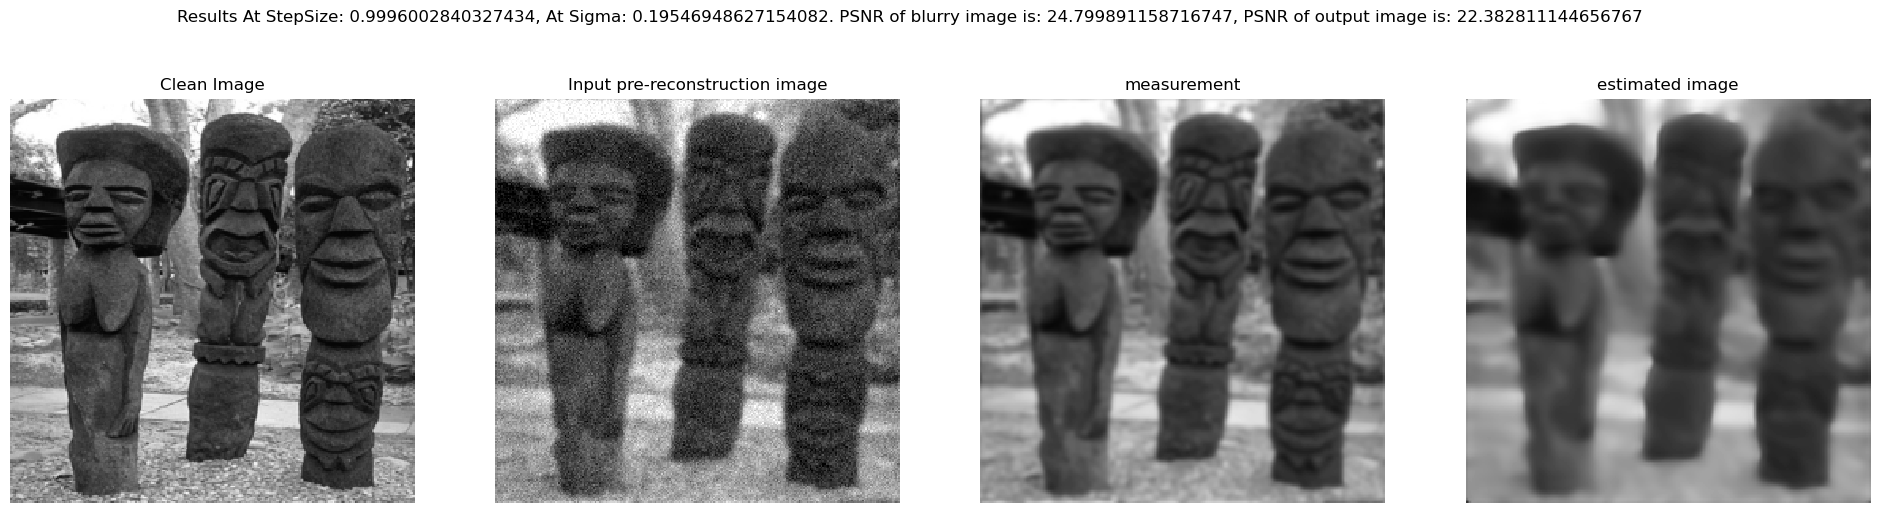

In [29]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {bestStepsize}, At Sigma: {bestMapSigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')